In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import torch

In [3]:
from behavior_model import LVBehaviorModel
from synthetic_model import LVTrajSynthetic

In [4]:
file_path = 'Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model

In [6]:
## Network Parameters 
input_size = 5
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
acc_min, acc_max, acc_interval = -9.5, 7, 0.25
output_size = int((acc_max - acc_min)/acc_interval) + 1

model_lv = LVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_lv.load_state_dict(torch.load('.\\weights\\bc_lv_val_05.pth')) 
model_lv.eval()

LVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=67, bias=True)
    (3): LogSoftmax(dim=2)
  )
)

## Trajectory Generation Algorithm

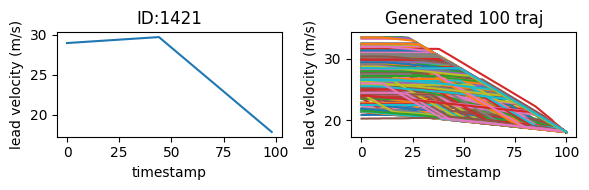

In [7]:
for _ in range(1):
    ID = random.randint(1, 5000)
#     ID = 2530
    ID = 1421
    v_l_i = df[df["id"]==ID].iloc[:, 3].to_numpy()
    v_f_i = df[df["id"]==ID].iloc[:, 2].to_numpy()
    d_i = df[df["id"]==ID].iloc[:, 4].to_numpy()
    t_i = df[df["id"]==ID].iloc[:, 1].to_numpy()

    #### Gen LV first
    n = 500 # number of trajectories
    V_inputLV, A_inputLV = np.zeros(n), np.zeros(n)
    V_f0_inputLV, A_f0_inputLV = np.zeros(n), np.zeros(n)

    a_0 = (v_l_i[-2]-v_l_i[-3])/0.05
    # V_inputLV = V_inputLV+v_l_i[-1]
    V_inputLV = V_inputLV+v_l_i[-2]
    A_inputLV = A_inputLV+a_0
    V_f0_inputLV = V_f0_inputLV+v_f_i[-2]
    A_f0_inputLV = A_f0_inputLV+(v_f_i[-2]-v_f_i[-3])/0.05

    KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=5,mode="rs",device=device)
    
    ## Create n replicated initial condition according to one original trajectories
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.plot(df[df["id"]==ID].iloc[:, 3].to_numpy())
    plt.title(f"ID:{ID}")
    plt.xlabel("timestamp")
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(1, 2, 2)
    plt.title("Generated 100 traj")
    for i in range(KM_l_LV.shape[0]):
        # plt.plot(KM_l[i,:,1])
        plt.plot(np.flip(KM_l_LV[i,:,1]))
    plt.xlabel("timestamp")
    plt.ylabel("lead velocity (m/s)")
    plt.tight_layout()
    plt.show()